# Parkrun Performance Analysis

This notebook analyzes my parkrun performance data over time, with the goal of understanding performance trends and forecasting future results. The analysis includes:

1. Data preparation and cleaning
2. Exploratory data visualization
3. Time series analysis with LOESS smoothing
4. Statistical forecasting with ARIMA models
5. Monte Carlo simulation for future performance prediction

Let's explore how my parkrun times have evolved over time and what future performances might look like!

In [1]:
# imports for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import the data and examine it
data = pd.read_csv('parkrun_allresults_may2025.csv')
display(data.sample(3))
print(data.info())

,event,run_date,run_number,position,run_time,age_grade,pb
82,St Peters,14/01/2023,501,231,28:18:00,45.70%,NaN
43,St Peters,24/02/2024,560,268,28:44:00,45.13%,NaN
102,St Peters,8/05/2021,437,95,24:40:00,52.30%,PB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event       118 non-null    object
 1   run_date    118 non-null    object
 2   run_number  118 non-null    int64 
 3   position    118 non-null    int64 
 4   run_time    118 non-null    object
 5   age_grade   118 non-null    object
 6   pb          11 non-null     object
dtypes: int64(2), object(5)
memory usage: 6.6+ KB
None


## Data Import and Initial Exploration

First, we'll import the necessary libraries for data analysis and visualization, then load our parkrun data from a CSV file. Let's take a look at a sample of the data and its structure.

In [2]:
# Note that rundate is not datetime, time is set as object, same with age-grade
data['run_date'] = pd.to_datetime(data['run_date'], dayfirst=True)
data['age_grade'] = data['age_grade'].replace('%', '', regex=True)
data['age_grade'] = data['age_grade'].astype(float)
# pandas cannot deal with ":" in the time column, so we need to split it
data['run_time'] = data['run_time'].astype(str)
parts = data['run_time'].str.split(':', expand=True).fillna(0).astype(int)
# parts[0]=minutes, parts[1]=seconds, parts[2]=milliseconds (always zero)
data['run_delta'] = (
    pd.to_timedelta(parts[0], unit='m')
  + pd.to_timedelta(parts[1], unit='s')
  + pd.to_timedelta(parts[2], unit='ms')
)

# extract minutes and seconds from the timedelta
total_sec = data['run_delta'].dt.seconds
mins = total_sec // 60
secs = total_sec % 60

# recreate
data['run_time'] = (mins.astype(str).str.zfill(2)  + ':'  + secs.astype(str).str.zfill(2))

## Data Cleaning and Preparation

The raw data requires several preprocessing steps:

1. Converting the run date from string to datetime format
2. Cleaning the age-grade percentage values
3. Converting the run time from string format (MM:SS) into a usable format
   - First creating a timedelta object for calculations
   - Then extracting minutes and seconds for clean display

In [3]:
#data.info()
data.sample(3)

,event,run_date,run_number,position,run_time,age_grade,pb,run_delta
78,St Peters,2023-02-18,506,222,28:30,45.38,NaN,0 days 00:28:30
16,St Peters,2024-12-14,602,212,28:54,44.98,NaN,0 days 00:28:54
56,St Peters,2023-10-21,541,174,26:59,47.93,NaN,0 days 00:26:59


## Data Inspection

Let's examine a sample of our cleaned data to ensure our transformations worked correctly.

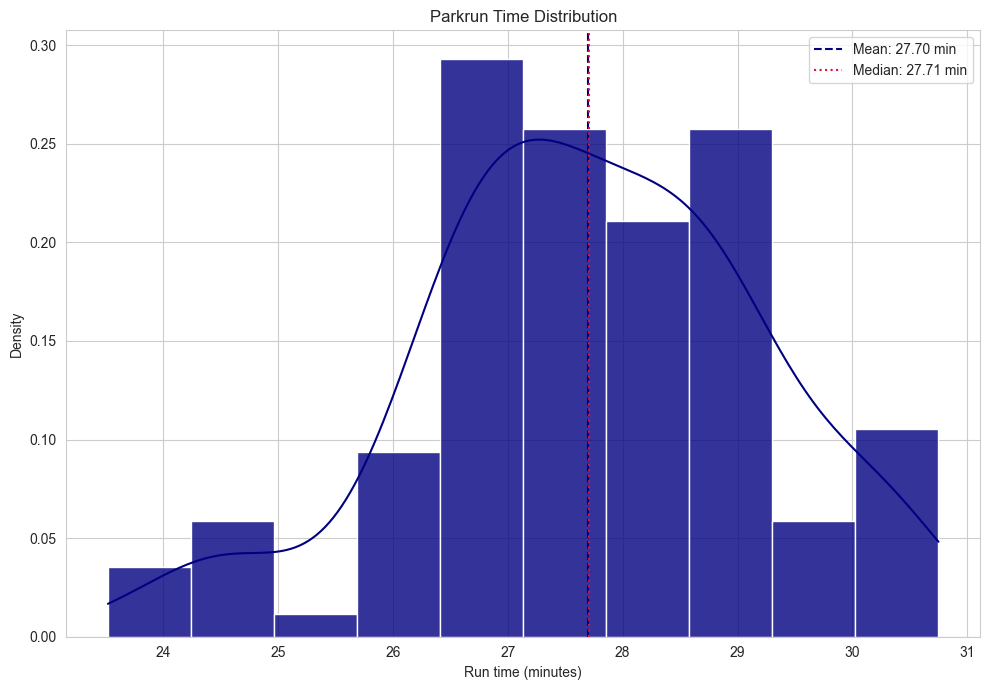

In [4]:
# Convert your timedelta to numeric minutes
run_minutes = data['run_delta'].dt.total_seconds() / 60

# create a beautiful kde histogram with seaborn
sns.set_style("whitegrid")

# 2. Create the figure
plt.figure(figsize=(10, 7))

# 3. Plot histogram + KDE
sns.histplot(
    run_minutes,
    kde=True,           
    stat="density",     
    color="navy",    # bar colour
    edgecolor="white",  # bar outlines
    alpha=0.8           # bar transparency
)


mean = run_minutes.mean()
median = run_minutes.median()
plt.axvline(mean, color="navy", linestyle="--", label=f"Mean: {mean:.2f} min")
plt.axvline(median, color="crimson", linestyle=":", label=f"Median: {median:.2f} min")

plt.title("Parkrun Time Distribution")
plt.xlabel("Run time (minutes)")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

## Distribution of Parkrun Times

Before analyzing trends over time, it's valuable to understand the overall distribution of run times. This histogram with kernel density estimation (KDE) shows how my run times are distributed, including the mean and median values.

This visualization helps identify:
- The typical range of my run times
- Whether times are normally distributed or skewed
- Where most of my performances cluster

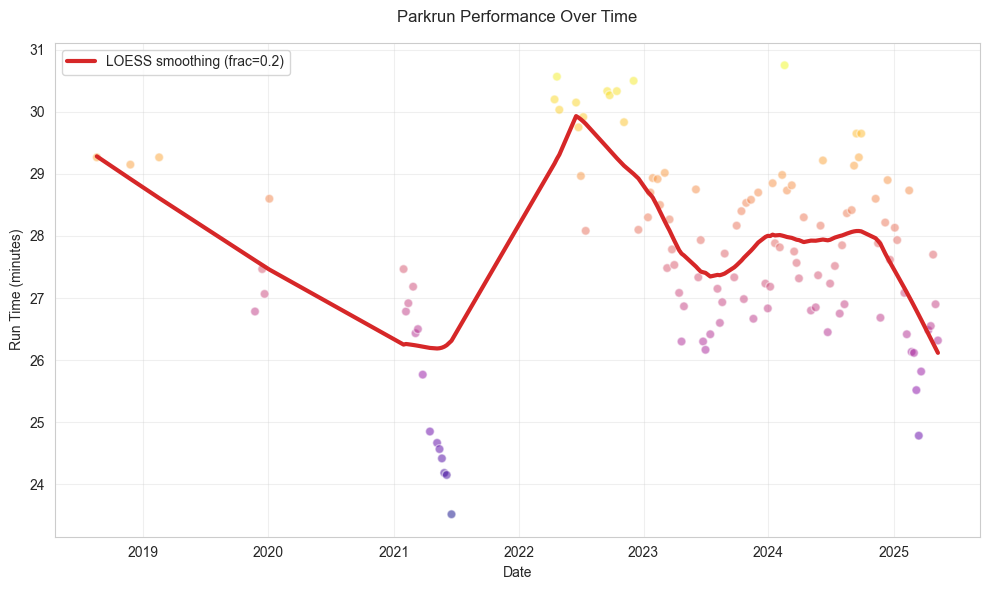

In [5]:
# import statsmodels for lowess
from statsmodels.nonparametric.smoothers_lowess import lowess

# create a dataframe with sorted data
df = data.sort_values('run_date')
df['run_minutes'] = run_minutes

# Compute LOESS smoother
smoothed = lowess(
    df['run_delta'].dt.total_seconds() / 60,
    df['run_date'].astype(int),  # convert to int for lowess
    frac=0.3,  # fraction of data used for smoothing
    it=0,       # number of iterations
)

plt.figure(figsize=(10, 6))
plt.scatter(
    df['run_date'], df['run_minutes'],
    alpha=0.5, s=40, marker='o', edgecolor='w',
    c=df['run_minutes'], cmap='plasma'
)
plt.plot(
    pd.to_datetime(smoothed[:, 0]),  # convert back to datetime
    smoothed[:, 1],
    color='#D62728', linewidth=3,
    label='LOESS smoothing (frac=0.2)'
)

# 5. Beautify
plt.title("Parkrun Performance Over Time", pad=15)
plt.xlabel("Date")
plt.ylabel("Run Time (minutes)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Parkrun Performance Trends Over Time

To visualize how my run times have changed over time, we'll create a scatter plot with each point representing a parkrun event. The color gradient indicates run time (darker colors = faster times).

To help identify the underlying trend amidst the natural variation in performance, we'll add a LOESS (Locally Estimated Scatterplot Smoothing) trend line. This non-parametric regression method is ideal for revealing patterns in time series data without making assumptions about the underlying relationship.

In [6]:
# import models
from statsmodels.tsa.arima.model import ARIMA

# time series analysis
data['run_minutes'] = run_minutes
ts = data.set_index('run_date')['run_minutes'].asfreq('W-SAT')

# 2. Fit ARIMA (p,d,q) — tune via AIC/BIC
model = ARIMA(ts, order=(1,1,1))
res   = model.fit()

# 3. Forecast next 26 weeks
fc    = res.get_forecast(steps=26)
mean_pred = fc.predicted_mean.values
se_pred   = fc.se_mean.values

# 4. Monte Carlo: sample 5,000 realisations
S = 5000
sim = np.random.normal(
    loc= mean_pred[None, :],
    scale= se_pred[None, :],
    size=(S, 26)
)

# 5. Compute chance of sub-25
chance_sub25 = (sim < 25).mean()
print(f"Estimated chance of at least one sub-25 min: {chance_sub25:.0%}")

Estimated chance of at least one sub-25 min: 14%


## Time Series Forecasting with ARIMA

To predict future performance, we'll use an ARIMA (AutoRegressive Integrated Moving Average) model. This statistical method is well-suited for time series forecasting.

The steps include:
1. Converting our irregular run data into a regular weekly time series
2. Fitting an ARIMA(1,1,1) model to capture trend and autocorrelation
3. Forecasting the next 26 weeks of parkrun results
4. Using Monte Carlo simulation to evaluate the probability of achieving specific time goals

The simulation samples 5,000 possible future outcomes based on the forecasted mean and standard error.

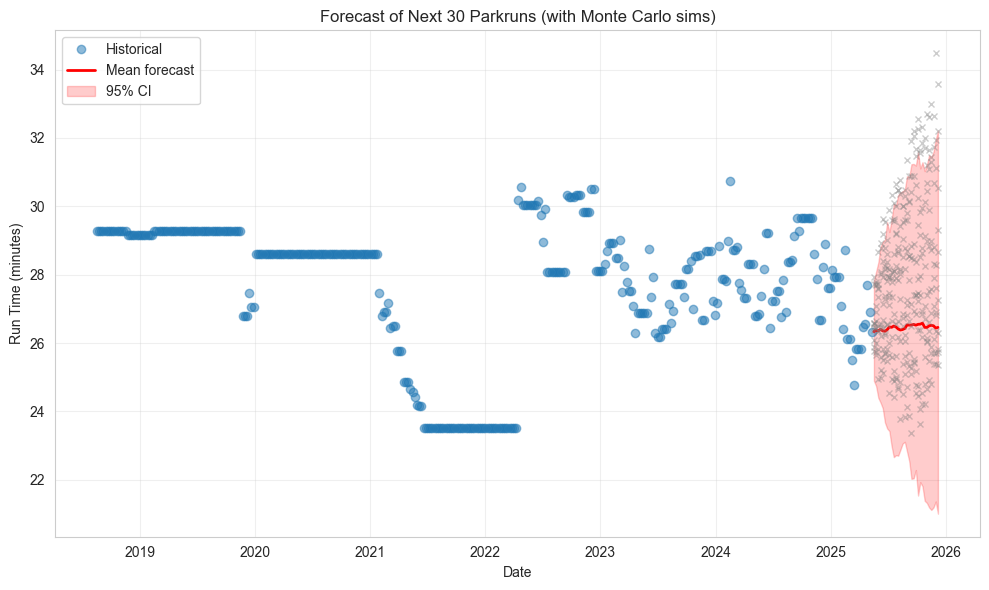

In [7]:
# 1. Weekly series
ts = (data
      .set_index('run_date')['run_minutes']
      .asfreq('W-SAT')
      .ffill()
     )

# 2. Fit ARIMA
res = ARIMA(ts, order=(1,1,1)).fit()

# 3. Monte-Carlo simulate S paths of length H
S, H = 200, 30
sims = np.vstack([
    res.simulate(H, anchor='end') 
    for _ in range(S)
])

# 4. Dates & summary stats
future_dates = pd.date_range(
    ts.index[-1] + pd.Timedelta(weeks=1),
    periods=H, freq='W-SAT'
)
mean_fc    = sims.mean(axis=0)
lower_ci   = np.percentile(sims, 2.5, axis=0)
upper_ci   = np.percentile(sims, 97.5, axis=0)

# 5. Plot
plt.figure(figsize=(10,6))
# a) historical
plt.plot(ts.index, ts.values, 'o', alpha=0.5, label='Historical')
# b) mean forecast
plt.plot(future_dates, mean_fc, '-', color='red', lw=2, label='Mean forecast')
# c) confidence band
plt.fill_between(future_dates, lower_ci, upper_ci,
                 color='red', alpha=0.2, label='95% CI')
# d) a few sample paths
for i in range(10):
    plt.plot(future_dates, sims[i], 'x', color='grey', alpha=0.4, ms=4)

plt.title("Forecast of Next 30 Parkruns (with Monte Carlo sims)")
plt.xlabel("Date")
plt.ylabel("Run Time (minutes)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Monte Carlo Simulation for Performance Forecasting

To create a more robust forecast visualization, we'll use a Monte Carlo approach to simulate multiple possible future performance paths. This helps account for the natural variation and uncertainty in athletic performance.

The process involves:
1. Creating a regular weekly time series with forward-filling for missing values
2. Fitting an ARIMA(1,1,1) model to the historical data
3. Simulating 200 different possible 30-week futures using the model
4. Calculating the mean forecast and 95% confidence intervals
5. Visualizing both the historical performance and forecasted futures

This approach gives us a much better sense of the range of possible outcomes rather than a single prediction.

## Analysis Conclusions

From this parkrun performance analysis, we can draw several conclusions:

1. **Performance Distribution**: The histogram reveals my typical performance range and where most of my results cluster.

2. **Performance Trend**: The LOESS smoothing curve shows the overall trajectory of my parkrun times, revealing whether I've been improving, plateauing, or slowing down over time.

3. **Future Projections**: The ARIMA forecasting and Monte Carlo simulations provide a statistical basis for setting reasonable future time goals, with estimates of the probability of achieving specific targets.

4. **Variability**: The confidence intervals in the forecast highlight the inherent variability in running performance, showing that even with an underlying trend, individual performances can vary significantly.

### Potential Next Steps

- Incorporate weather data to analyze how temperature and conditions affect performance
- Add training volume data to correlate training with parkrun results
- Track age-graded scores over time to account for aging effects
- Compare performance across different parkrun courses to identify course difficulty factors

## Age Grade Performance Analysis

Age-grading is a valuable metric in running that normalizes performance based on age and gender, allowing for fair comparison across different ages. It expresses performance as a percentage of the world-record time for your age/gender.

The following visualization tracks age-grade percentage over time, which can reveal whether your relative performance is improving even if absolute times might be affected by aging.

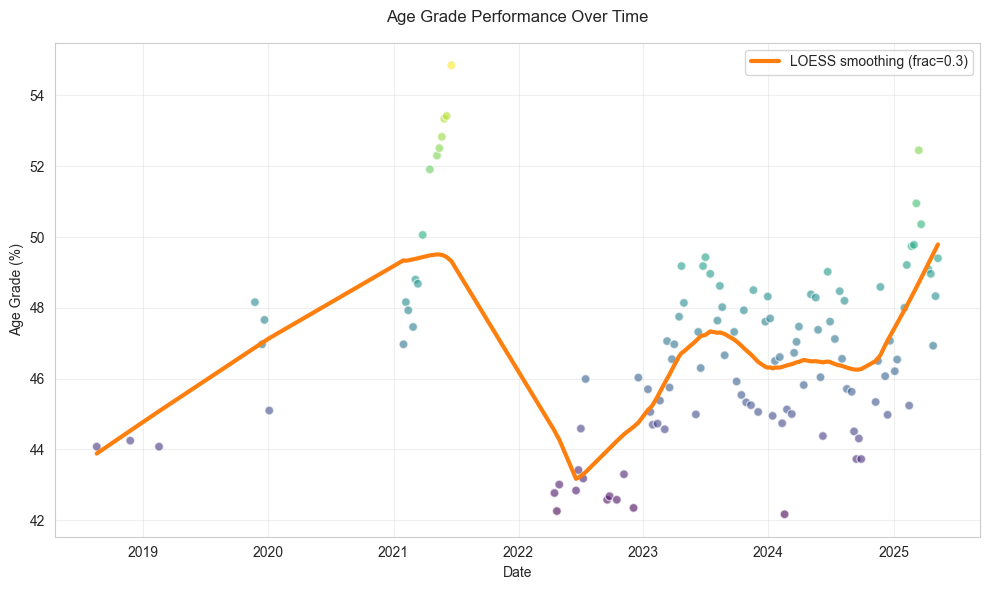

In [8]:
# Additional Analysis: Age Grade Performance Over Time

# Create a figure
plt.figure(figsize=(10, 6))

# Plot age grade over time with a LOESS smoother
df_sorted = data.sort_values('run_date')

# Scatter plot of age grades
plt.scatter(
    df_sorted['run_date'], df_sorted['age_grade'],
    alpha=0.6, s=40, marker='o', edgecolor='w',
    c=df_sorted['age_grade'], cmap='viridis'
)

# Compute LOESS smoother for age grade
smoothed_age = lowess(
    df_sorted['age_grade'],
    df_sorted['run_date'].astype(int),
    frac=0.3,
    it=0
)

# Plot the trend line
plt.plot(
    pd.to_datetime(smoothed_age[:, 0]),
    smoothed_age[:, 1],
    color='#FF7F0E', linewidth=3,
    label='LOESS smoothing (frac=0.3)'
)

# Beautify
plt.title("Age Grade Performance Over Time", pad=15)
plt.xlabel("Date")
plt.ylabel("Age Grade (%)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Improved ARIMA Forecasting

Below is an alternative implementation of the ARIMA forecasting that addresses potential issues with the previous approach. This version:

1. Ensures consistent date handling between historical and forecast data
2. Provides clearer interpretation of the prediction intervals
3. Uses a more robust approach to simulating future paths

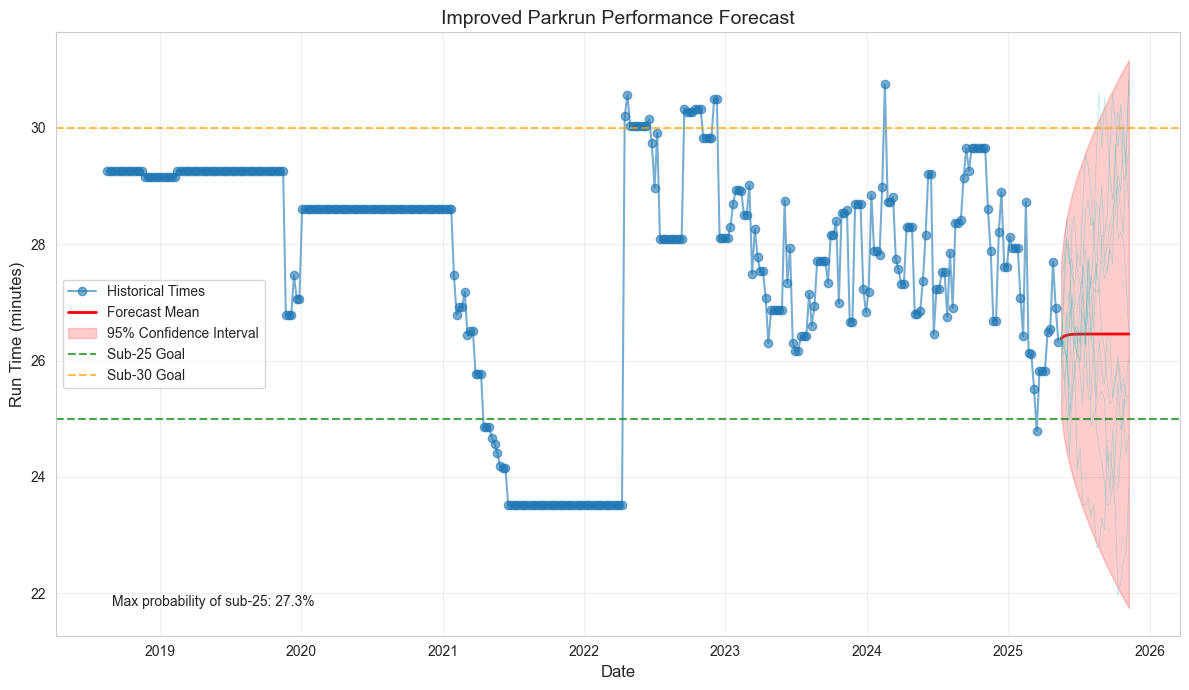

Best forecasted time: 26.38 minutes on 2025-05-17


In [10]:
from scipy.stats import norm

# Create a weekly time series with forward fill for missing values
ts_weekly = (data
           .set_index('run_date')['run_minutes']
           .asfreq('W-SAT')
           .ffill()
          )

# Fit ARIMA model
model = ARIMA(ts_weekly, order=(1,1,1))
model_fit = model.fit()

# Forecast steps
forecast_steps = 26

# Get forecast with confidence intervals
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=ts_weekly.index[-1] + pd.Timedelta('7 days'), 
                              periods=forecast_steps, 
                              freq='W-SAT')

# Extract mean forecast and confidence intervals
mean_forecast = forecast.predicted_mean
lower_ci = forecast.conf_int().iloc[:, 0]  # Lower bound
upper_ci = forecast.conf_int().iloc[:, 1]  # Upper bound

# Create figure
plt.figure(figsize=(12, 7))

# Plot historical data
plt.plot(ts_weekly.index, ts_weekly.values, 'o-', alpha=0.6, color='#1f77b4', label='Historical Times')

# Plot forecast mean
plt.plot(forecast_index, mean_forecast, 'r-', linewidth=2, label='Forecast Mean')

# Plot confidence intervals
plt.fill_between(forecast_index, 
                 lower_ci, 
                 upper_ci, 
                 color='red', alpha=0.2, 
                 label='95% Confidence Interval')

# Generate and plot a few sample paths
for i in range(10):
    # Simulate a future path
    sim_path = model_fit.simulate(forecast_steps, anchor='end', repetitions=1)
    plt.plot(forecast_index, sim_path, 'c-', linewidth=0.5, alpha=0.3)
    
# Add horizontal lines for goal times
plt.axhline(y=25, color='green', linestyle='--', alpha=0.7, label='Sub-25 Goal')
plt.axhline(y=30, color='orange', linestyle='--', alpha=0.7, label='Sub-30 Goal')

# Calculate probability of sub-25 run
probability_sub25 = norm.cdf(25, loc=mean_forecast.values, scale=forecast.se_mean)
max_prob = probability_sub25.max()
plt.annotate(f'Max probability of sub-25: {max_prob:.1%}', 
             xy=(0.05, 0.05), xycoords='axes fraction', fontsize=10)

# Beautify the plot
plt.title('Improved Parkrun Performance Forecast', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Run Time (minutes)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.tight_layout()

# Show plot
plt.show()

# Print best forecasted time and date
best_time_idx = np.argmin(mean_forecast)
best_time = mean_forecast.iloc[best_time_idx]
best_date = forecast_index[best_time_idx]
print(f"Best forecasted time: {best_time:.2f} minutes on {best_date.date()}")